# Modeling

This notebook aims to build a model to predict the results of several cancer tests given information about the patients.

#### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

#### Load Data

Training some models with both standardized and non-standardized data revealed that the standardized data was superior, so we are only going to be using the standardized data from here on out.

In [2]:
train = pd.read_csv('../data/standardized_train.csv', index_col=0)
test = pd.read_csv('../data/standardized_test.csv', index_col=0)

train.head()

,Age,Number of sexual partners,First sexual intercourse,Smokes (years),Smokes (packs/year),Hormonal Contraceptives (years),IUD (years),STDs (number),STDs: Number of diagnosis,STDs: Time since first diagnosis,...,STDs: Time since first diagnosis.1,STDs: Time since last diagnosis.1,Dx:Cancer,Dx:HPV,Dx,Missing STDs columns,Hinselmann,Schiller,Citology,Biopsy
0,-1.386503,-0.310570,-1.074217,-0.290889,-0.196444,-0.538095,-0.229997,-0.294975,-0.288060,-0.214723,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.351071,1.440227,-0.356674,-0.290889,-0.196444,-0.538095,3.691611,1.556062,2.941987,4.323410,...,11.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.343958,-0.310570,0.719642,-0.290889,-0.196444,-0.538095,-0.229997,-0.294975,-0.288060,-0.214723,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.343958,0.273029,0.719642,-0.290889,-0.196444,0.022743,-0.229997,-0.294975,-0.288060,-0.214723,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.466910,0.273029,0.719642,-0.290889,-0.196444,-0.538095,3.691611,-0.294975,-0.288060,-0.214723,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


I hate to be backtracking too much to previous steps of the data sicence pipeline, but this is what data science is all about! Training and testing on 4 separate cancer tests feels a bit much, so we're going to find whichever test seems to correlate the most with an actual positive diagnosis and move on testing for just that one. This one feels so obvious that it probably should have already been done.

In [3]:
def roc_auc(x, y):
    fpr, tpr, thresholds = roc_curve(x, y)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC')
    plt.legend(loc='lower right')
    plt.show()

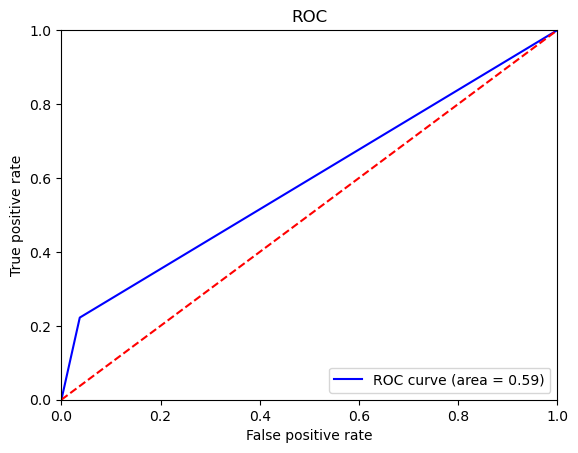

In [4]:
df = pd.concat([train, test])

roc_auc(df['Dx:Cancer'], df['Hinselmann'])

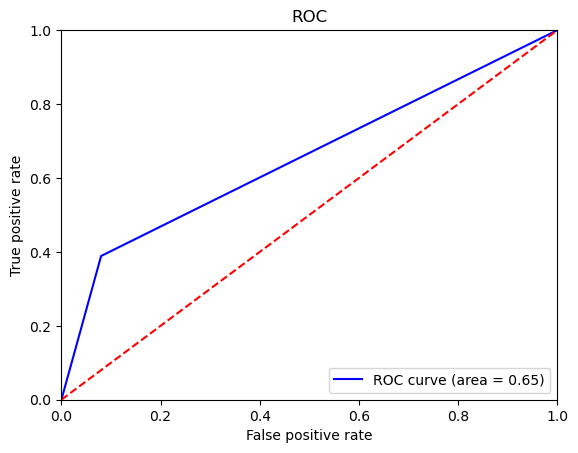

In [5]:
roc_auc(df['Dx:Cancer'], df['Schiller'])

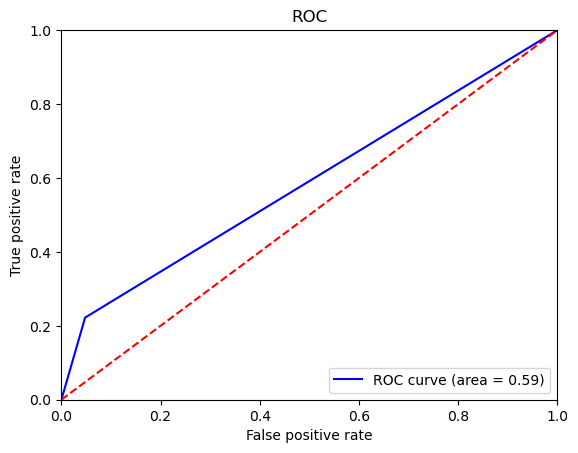

In [6]:
roc_auc(df['Dx:Cancer'], df['Citology'])

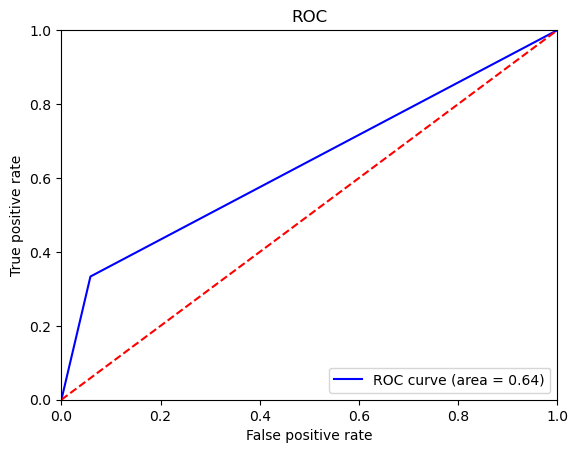

In [7]:
roc_auc(df['Dx:Cancer'], df['Biopsy'])

It looks like Schiller is the test that points the most towards a positive cancer diagnosis, beating the biopsy test by just a hair. Because we likely want to know about the actual presence of cancer, we are going to limit our predictions to the test that shares the closest relationship to a positive cancer diagnosis.

One more issue that should have been treated differently from the start (hindsight is 20/20) is the problem of the patients who left all of the STDs columns blank. This accounts for about 12% of our patients. While it wouldn't be ideal to drop this large chunk of data, they *are* missing some of the *absolute* most important features for predicting cervical cancer. This greatly inhibits the power we have to predict their status.

In [8]:
n_patients = df.shape[0]
n_missing_stds_patients = df[df['Missing STDs columns'] == 1].shape[0]
missing_stds_proportion = n_missing_stds_patients / n_patients

print('The patients who didn\'t answer the STDs questions make up {:.1f}% of the patients.'.format(missing_stds_proportion * 100))

n_schiller_pos = df['Schiller'].value_counts()[1]
n_schiller_pos_ratio = n_schiller_pos / n_patients

n_schiller_pos_missing_STDs = df[df['Missing STDs columns'] == 1]['Schiller'].value_counts()[1]
n_schiller_pos_missing_ratio = n_schiller_pos_missing_STDs / n_missing_stds_patients

print('{:.1f}% of patients tested positive on the Schiller test'.format(n_schiller_pos_ratio * 100))
print('{:.1f}% of patients who didn\'t answer STD questions tested positive on Schiller test'.format(n_schiller_pos_missing_ratio * 100))

The patients who didn't answer the STDs questions make up 11.9% of the patients.
8.7% of patients tested positive on the Schiller test
1.0% of patients who didn't answer STD questions tested positive on Schiller test


 We may as well remove these patients from our data as they don't account for many of the positive test results and they would skew our results. We can also go ahead and remove the 'Missing STDs columns' column as it would be constant now.

In [9]:
train.reset_index(drop=True, inplace=True)
missing_stds_indices = train.index[train['Missing STDs columns'] == 1].tolist()
train.drop(index=missing_stds_indices, columns=['Missing STDs columns'], inplace=True)

test.reset_index(drop=True, inplace=True)
missing_stds_indices = test.index[test['Missing STDs columns'] == 1].tolist()
test.drop(index=missing_stds_indices, columns=['Missing STDs columns'], inplace=True)

Split the data into X and y for each set of data. We will drop the other test results as they may share some correlation with our test result of interest.

In [10]:
X_train = train.drop(columns=['Schiller']).reset_index(drop=True)
y_train = train[['Schiller']].reset_index(drop=True)

X_test = test.drop(columns=['Schiller']).reset_index(drop=True)
y_test = test[['Schiller']].reset_index(drop=True)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

### Logistic Regression

In [11]:
# define param_grid
logreg_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'class_weight': ['balanced'],
    'max_iter': [5000, 12500, 15000, 17500]
}

# initialize logistic regression model
logreg = LogisticRegression()

# initialize a gridsearchcv model
gridsearch_logreg = GridSearchCV(logreg, logreg_param_grid, scoring='f1_macro', n_jobs=-1)

# perform hyperparameter optimization on the logistic regression model
gridsearch_logreg.fit(X_train, y_train)

print('Best params: {}\n    Best score: {}\n'.format(gridsearch_logreg.best_params_, gridsearch_logreg.best_score_))

Best params: {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 5000, 'penalty': 'l1', 'solver': 'saga'}
    Best score: 0.8510637558379495



              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97       136
         1.0       0.76      0.81      0.79        16

    accuracy                           0.95       152
   macro avg       0.87      0.89      0.88       152
weighted avg       0.96      0.95      0.95       152



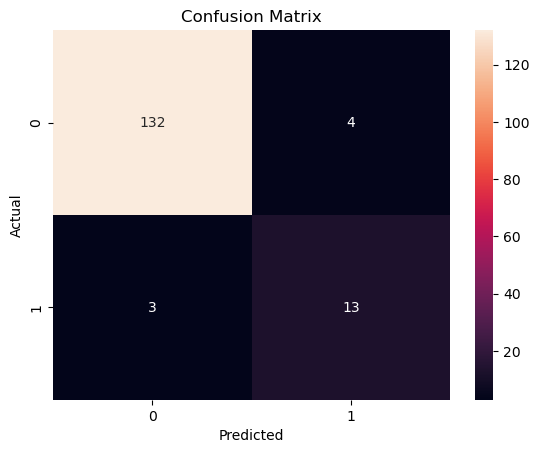

In [12]:
# predict and show results
y_pred = gridsearch_logreg.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

report = classification_report(y_test, y_pred)
print(report)

### Random Forest

In [13]:
rf_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced'],
    'bootstrap': [True, False]
}

# initialize random forest model
rf = RandomForestClassifier()

gridsearch_rf = GridSearchCV(rf, rf_param_grid, scoring='f1_macro', n_jobs=-1)

# perform hyperparameter optimization on random forest model
gridsearch_rf.fit(X_train, y_train)

print('Best params: {}\n    Best score: {}\n'.format(gridsearch_rf.best_params_, gridsearch_rf.best_score_))

Best params: {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
    Best score: 0.8884623040069434



              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       136
         1.0       0.87      0.81      0.84        16

    accuracy                           0.97       152
   macro avg       0.92      0.90      0.91       152
weighted avg       0.97      0.97      0.97       152



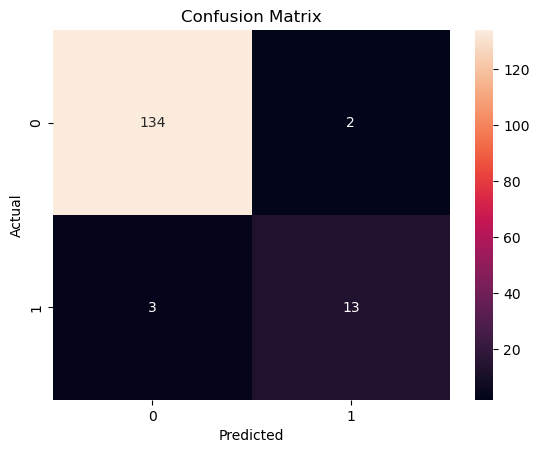

In [14]:
# predict and show results
y_pred = gridsearch_rf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

report = classification_report(y_test, y_pred)
print(report)

### SVM (Support Vector Machine)

In [15]:
svm_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.001,  0.01, 0.1, 1],
    'degree': [2, 3, 4]
}

svm = SVC()

# perform hyperparam optimization on svm model
randomizedsearch_svm = RandomizedSearchCV(svm, svm_param_grid, scoring='f1_macro', n_jobs=-1)
randomizedsearch_svm.fit(X_train, y_train)

print('Best params: {}\n    Best score: {}\n'.format(randomizedsearch_svm.best_params_, randomizedsearch_svm.best_score_))

Best params: {'kernel': 'linear', 'gamma': 'scale', 'degree': 4, 'C': 1}
    Best score: 0.8950524817648106



              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       136
         1.0       0.87      0.81      0.84        16

    accuracy                           0.97       152
   macro avg       0.92      0.90      0.91       152
weighted avg       0.97      0.97      0.97       152



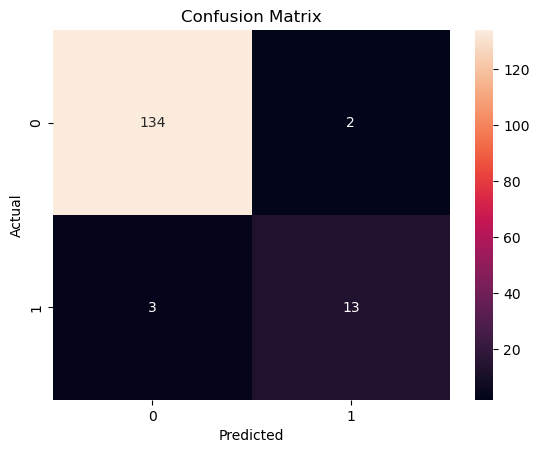

In [16]:
# predict and show results
y_pred = randomizedsearch_svm.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

report = classification_report(y_test, y_pred)
print(report)


Out of these models, the best one would be the SVM. It has approximately the same f1-macro average as the random forest model but trains much faster. The features do, however, include the results of the other tests. Let's see what happens if we start to remove these tests from our data before training.

Best params: {'kernel': 'linear', 'gamma': 1, 'degree': 3, 'C': 100}
    Best score: 0.8335989580881222

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97       136
         1.0       0.91      0.62      0.74        16

    accuracy                           0.95       152
   macro avg       0.93      0.81      0.86       152
weighted avg       0.95      0.95      0.95       152



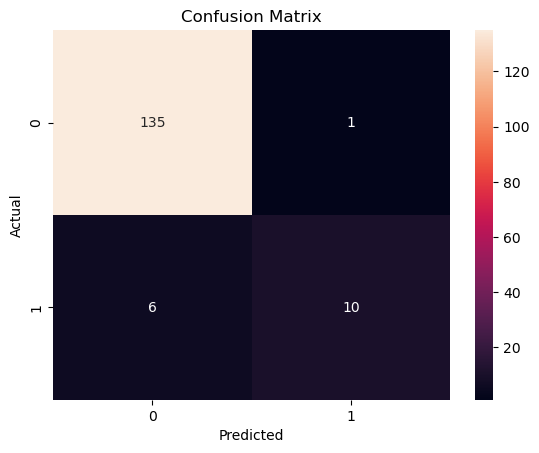

In [17]:
X_train.drop(columns=['Hinselmann'], inplace=True)
X_test.drop(columns=['Hinselmann'], inplace=True)

svm = SVC()

randomizedsearch_svm = RandomizedSearchCV(svm, svm_param_grid, scoring='f1_macro', n_jobs=-1)
randomizedsearch_svm.fit(X_train, y_train)

print('Best params: {}\n    Best score: {}\n'.format(randomizedsearch_svm.best_params_, randomizedsearch_svm.best_score_))

y_pred = randomizedsearch_svm.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

report = classification_report(y_test, y_pred)
print(report)

Best params: {'kernel': 'linear', 'gamma': 1, 'degree': 2, 'C': 10}
    Best score: 0.6914379663913627

              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94       136
         1.0       0.50      0.19      0.27        16

    accuracy                           0.89       152
   macro avg       0.71      0.58      0.61       152
weighted avg       0.87      0.89      0.87       152



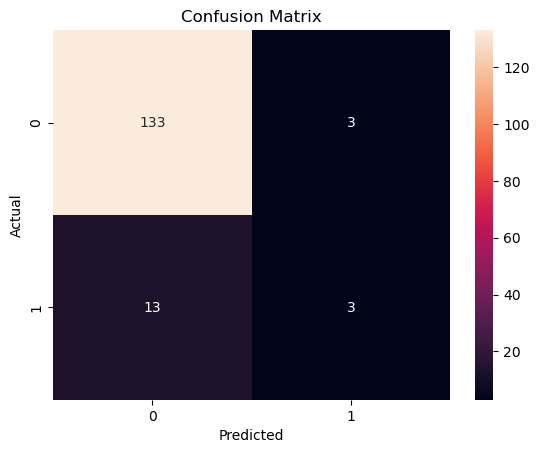

In [18]:
X_train.drop(columns=['Biopsy'], inplace=True)
X_test.drop(columns=['Biopsy'], inplace=True)

svm = SVC()

randomizedsearch_svm = RandomizedSearchCV(svm, svm_param_grid, scoring='f1_macro', n_jobs=-1)
randomizedsearch_svm.fit(X_train, y_train)

print('Best params: {}\n    Best score: {}\n'.format(randomizedsearch_svm.best_params_, randomizedsearch_svm.best_score_))

y_pred = randomizedsearch_svm.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

report = classification_report(y_test, y_pred)
print(report)

As we remove one test, our f1-micro average drops from 0.91 to 0.86, and removing another test drops it further to 0.61, making it only 10% better than a random guess. This could perhaps be a useful method of reducing the number of tests patients have to take from 4 to 2 as we can be fairly confident we are correctly predicting their results for the remaining tests given the two. If we are looking to predict results rather than doing any testing, we may need to reconsider as the model quickly declines in accuracy.